In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/My\ Drive/TMRS

dataset.txt  filtered_dataset.json


In [3]:
import json

input_file = "/content/drive/My Drive/TMRS/dataset.txt"
output_file = "/content/drive/My Drive/TMRS/filtered_dataset.json"

filtered_data = []

with open(input_file, "r", encoding="utf-8") as file:
    content = file.read()

raw_entries = content.splitlines()

for entry in raw_entries:
    try:
        data = json.loads(entry)

        filtered_data.append({
            "func": data["func"],
            "target": data["target"]
        })
    except json.JSONDecodeError:
        print(f"Skipping invalid JSON entry: {entry}")

with open(output_file, "w", encoding="utf-8") as file:
    json.dump(filtered_data, file, indent=4)

print(f"Filtered data saved to {output_file}")

Filtered data saved to /content/drive/My Drive/TMRS/filtered_dataset.json


In [4]:
import json

input_file = "/content/drive/My Drive/TMRS/filtered_dataset.json"

target_0_count = 0
target_1_count = 0

with open(input_file, "r", encoding="utf-8") as file:
    data = json.load(file)

for entry in data:
    if entry["target"] == 0:
        target_0_count += 1
    elif entry["target"] == 1:
        target_1_count += 1

print(f"Count of target = 0: {target_0_count}")
print(f"Count of target = 1: {target_1_count}")


Count of target = 0: 855
Count of target = 1: 889


In [5]:
%pip install transformers datasets torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [6]:
import json

# Load dataset (replace with your dataset)
def load_data(file_path):

    try:
        with open(file_path, "r", encoding="utf-8") as file:
            data = json.load(file)
            return data
    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in file: {file_path}")
    return []

data = load_data("/content/drive/My Drive/TMRS/filtered_dataset.json")

for item in data:
    if 'target' in item:
        item['label'] = item.pop('target')

print(data[1])

{'func': 'LEX::sp_variable_declarations_table_rowtype_finalize(THD *thd, int nvars,\n                                                     const LEX_CSTRING &db,\n                                                     const LEX_CSTRING &table,\n                                                     Item *def)\n{\n  Table_ident *table_ref;\n  if (unlikely(!(table_ref=\n                 new (thd->mem_root) Table_ident(thd, &db, &table, false))))\n    return true;\n  // Loop through all variables in the same declaration\n  for (uint i= 0 ; i < (uint) nvars; i++)\n  {\n    sp_variable *spvar= spcont->get_last_context_variable((uint) nvars - 1 - i);\n    spvar->field_def.set_table_rowtype_ref(table_ref);\n    sphead->fill_spvar_definition(thd, &spvar->field_def, &spvar->name);\n  }\n  if (sp_variable_declarations_set_default(thd, nvars, def))\n    return true;\n  // Make sure sp_rcontext is created using the invoker security context:\n  sphead->m_flags|= sp_head::HAS_COLUMN_TYPE_REFS;\n  spcont-

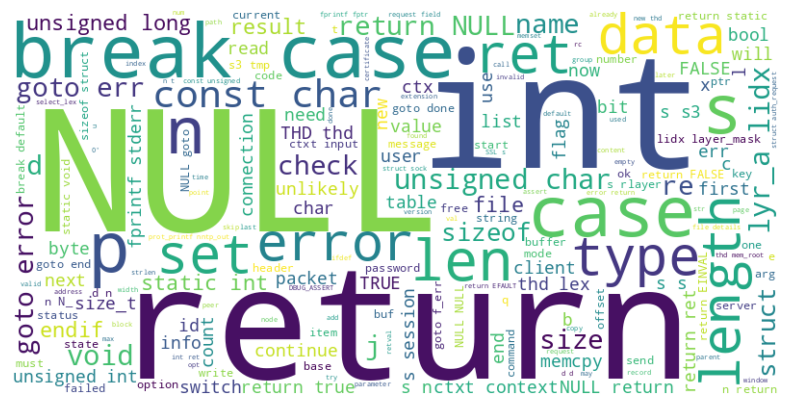

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = " ".join([item["func"] for item in data])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [12]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

MODEL_NAME = "microsoft/codebert-base"
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)  # Binary classification

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

def tokenize_function(examples):
    return tokenizer(examples["func"], padding="max_length", truncation=True, max_length=512)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

tokenized_train = tokenized_train.with_format("torch")
tokenized_test = tokenized_test.with_format("torch")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

training_args = TrainingArguments(
    output_dir="./codebert-finetuned",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

model.save_pretrained("./codebert-finetuned")
tokenizer.save_pretrained("./codebert-finetuned")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1395 [00:00<?, ? examples/s]

Map:   0%|          | 0/349 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-2b1c7f40ba6d>:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.376600,0.312685,0.885387,0.892473,0.842640,0.948571
2,0.263900,0.199849,0.957020,0.957265,0.954545,0.960000
3,0.001600,0.212434,0.959885,0.960674,0.944751,0.977143
4,0.001200,0.213511,0.962751,0.963380,0.950000,0.977143
5,0.000600,0.267187,0.959885,0.961538,0.925926,1.000000
6,0.000200,0.180284,0.971347,0.971429,0.971429,0.971429
7,0.000100,0.169443,0.979943,0.979827,0.988372,0.971429
8,0.000100,0.192241,0.968481,0.968839,0.960674,0.977143
9,0.000100,0.193898,0.968481,0.968661,0.965909,0.971429
10,0.000100,0.190317,0.971347,0.971429,0.971429,0.971429


('./codebert-finetuned/tokenizer_config.json',
 './codebert-finetuned/special_tokens_map.json',
 './codebert-finetuned/vocab.json',
 './codebert-finetuned/merges.txt',
 './codebert-finetuned/added_tokens.json')

In [16]:
from transformers import pipeline

classifier = pipeline("text-classification", model="./codebert-finetuned", tokenizer=tokenizer)

# Test on new code
code_sample = "int main() { char buffer[10] = \"hello\"; char copy[10]; strcpy(copy, buffer);}"
result = classifier(code_sample)
print(result)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_0', 'score': 0.9999245405197144}]
